# Training GAN networks

In [1]:
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import time
import os
import numpy as np
import tensorflow as tf
from IPython import display
from importlib import reload
import model_fcts as mod
import preprocessing_fcts as pp
import loss_fcts as loss

from model_fcts import Generator256, Generator512, naderi_gen

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
OUTPUT_CHANNELS = 1
BATCH_SIZE = 1
EPOCHS = 40
TRAIN_LENGTH = 8708 #size of the training dataset
IMAGE_FREQ = 1000

#### Functions in the notebook : 
 - train_GAN : for given parameters, prepares a GAN network to be trained with the function GAN_fit, returns the value of the lowest RMSE computed on the test dataset after each epoch of training
 - GAN_fit : trains GAN networks, checkpoints of the GAN after the 5 epochs with the lowest RMSE are saved, values of loss functions during training are saved for tensorboard
 - train_step : applies 1 training step to the GAN

In [3]:
def train_GAN(net_type, res, name, rgb=False, fm=False, grad=False, deconv=True):
    """
    Train a GAN network, given the parameters given in the arguments : 
    - net_type : string corresponding to a generator defined in 'model_fcts.py'
    - res : int, either 256 or 512 for an input DSM of either 256x256 or 512x512 pixels
    - name : string, used to name the checkpoints and tensorboard logs directories for this GAN
    - grad : whether or not use the gradient/normal components in the generator's loss function
    - rgb : bool, whether or not the rgb channels of the orthophotographs are included in the input. If False, only the DSM 
    - fm : bool, whether or not feature matching is used
    - deconv: bool, whether or not deconvolutions are used in the generator. If false, the alternative upsampling method is used
    
    The GAN is trained, a checkpoint is recorded of the epoch where it scores the lowest RMSE on the test dataset
    The RMSE of the final epoch is returned
    """
    perfs = []
    # load, normalize and batch the train and test datasets
    raw_train_dataset, raw_test_dataset = pp.load_tf_ds(res)
    train_dataset, test_dataset = pp.normalize_tf_dataset(raw_train_dataset, rgb), pp.normalize_tf_dataset(raw_test_dataset, rgb)
    train_dataset, test_dataset = train_dataset.batch(BATCH_SIZE), test_dataset.batch(BATCH_SIZE)
    
    spe = TRAIN_LENGTH // BATCH_SIZE #steps per epoch
    
    
    inp_channels = 1
    if rgb:
        inp_channels += 3
    
    #define the generator
    model_type = globals()[net_type]
    generator = model_type(inp_channels, res, deconv=deconv)
    #define the discriminator
    disc_name = 'Discriminator'
    if fm:
        disc_name += '_fm2_'
    disc_name += str(res)
    
    Discriminator = getattr(mod, disc_name) 
    discriminator = Discriminator(inp_channels, res)
    #directory with logs for tensorboard
    log_dir="logs/gan/"+ "fit/" + name

    summary_writer = tf.summary.create_file_writer(
      log_dir)
    
    start = time.time()
    print(EPOCHS*spe)
    #start training
    RMSE, RMSE_ep = GAN_fit(train_dataset, test_dataset, EPOCHS*spe, generator, discriminator, inp_channels, summary_writer, name, fm=fm, grad=grad)
    print('time : ' + str(time.time() - start) + ' s')
    
    print(RMSE)
    print(RMSE_ep)
    
    return RMSE

In [4]:
def GAN_fit(train_ds, test_ds, steps, generator, discriminator, inp_channels, summary_writer, name, fm, grad):
    """
    Trains a given GAN, saves tensorboard logs, a checkpoint at the epoch with the lowest RMSE computed on the test dataset, and 3 intermediate images at each epoch
    Inputs : 
    - train_ds : tensorflow dataset (x = normalized DSM (+ rgb channels of orthophoto), y=normalized DTM)
    - test_ds : same format as train_ds
    - steps : int,  number of training steps (= number of epochs * number of steps per epoch(= length of train dataset/batch size))
    - generator : model of the generator to train (tf.keras.Model or Generator class from 'model_fcts.py')
    - discriminator : model of the discriminator to train (tf.keras.Model)
    - inp channels : int, 1 (or 4 if RGB==True)
    - summary_writer : tf.summary.SummaryWriter object, to record the logs for tensorboard
    - name, it, fm : see "train_GAN" function above
    """
    
    checkpoint_dir = 'training_checkpoints/' + name
    
    
    gen_op = generator_optimizer
    disc_op = discriminator_optimizer
    
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=gen_op,
                                     discriminator_optimizer=disc_op,
                                     generator=generator,
                                     discriminator=discriminator)
    manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
    
    min_RMSE=20
    min_RMSE_ep=0
    
    image_dir = 'intermediate_images/' + name + '/' 
    os.mkdir(image_dir)
    example_list = [(inp, tar) for (inp, tar) in test_ds.take(3)]
    example_input, example_target = example_list[0][0], example_list[0][1]
    start = time.time()
    
    image_freq = IMAGE_FREQ // BATCH_SIZE
    
    generator.build((res,res,inp_channels))
    discriminator.build(((res,res,inp_channels), (res,res,1)))

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate(start=0):
        if (step) % image_freq == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            mod.generate_images(generator, example_input, example_target, inp_channels=inp_channels)
            print(f"Step: {step//1000}k")
        

        train_step(generator, discriminator, input_image, target, step, summary_writer, fm, grad)
        
    # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every epoch
        if step % (TRAIN_LENGTH) == 0 or step == (steps-1):
            im_num = 1
            for example in example_list:
                example_input2 = example[0]
                prediction = generator(example_input2, training=True)
                np.save(image_dir + str(int(step)//1000*BATCH_SIZE) + '_' + str(im_num),np.array(prediction))
                im_num += 1
                
            # Record the RMSE of the predictions on the test dataset
            # A checkpoint is saved if the RSME is the lowest yet
            preds = generator.predict(test_ds)
            rmse = mod.test_RMSE(preds)
            if rmse < min_RMSE:
                min_RMSE = rmse
                min_RMSE_ep = step//(TRAIN_LENGTH)
                manager.save()
            with summary_writer.as_default():
                tf.summary.scalar('RMSE', rmse, step=step//(TRAIN_LENGTH))
    return min_RMSE, min_RMSE_ep  

In [5]:
@tf.function
def train_step(generator, discriminator, input_image, target, step, summary_writer, fm, grad):
    """
    1 training step of the GAN
    The same function is copied and pasted hereunder in order to train multiple gan one after the other and not generate an error from tensorflow
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        if fm:
            if grad:
                gen_total_loss, gen_gan_loss, gen_l1_loss, fm_loss, grad_loss = loss.generator_fm_grad_loss(disc_generated_output, disc_real_output, gen_output, target)
            else:
                gen_total_loss, gen_gan_loss, gen_l1_loss, fm_loss = loss.generator_fm_loss2(disc_generated_output, disc_real_output, gen_output, target)
            disc_loss = loss.discriminator_loss(disc_real_output[-1], disc_generated_output[-1])
            
        else:
            if grad:
                gen_total_loss, gen_gan_loss, gen_l1_loss, grad_loss = loss.generator_grad_loss(disc_generated_output, gen_output, target)
            else:
                gen_total_loss, gen_gan_loss, gen_l1_loss = loss.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = loss.discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step*BATCH_SIZE//1000)
        if grad:
            tf.summary.scalar('gen_grad_loss', grad_loss, step=step*BATCH_SIZE//1000)
        if fm:
            tf.summary.scalar('fm_loss', fm_loss, step=step*BATCH_SIZE//1000)

In [6]:
%tensorboard --logdir /home/student/data/logs/gan --host 0.0.0.0

In [7]:
"""
For this example, to go faster, let us redifine these parameters : 
"""
EPOCHS = 1
TRAIN_LENGTH = 1000 #size of the training dataset
IMAGE_FREQ = 999

Time taken for 1000 steps: 123.53 sec



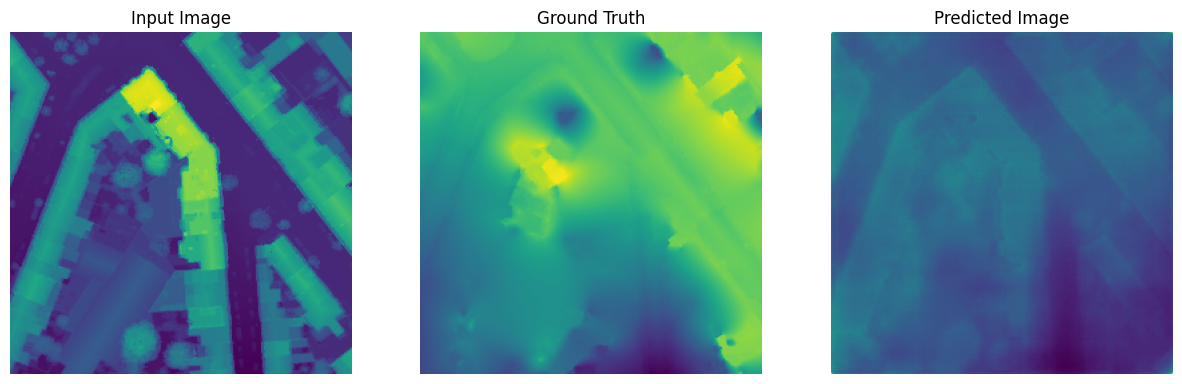

Step: 0k
1024/1024 [==============================] - 14s 14ms/step
time : 151.72822737693787 s
2.183217862079504
tf.Tensor(0, shape=(), dtype=int64)


In [8]:
params = [{'net_type':'Generator256', 'res':256, 'name':'TEST', 'grad':True, 'rgb':True, 'fm':True}
         ]
results_RMSE = []

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#name = params[0]['name']
#res = params[0]['res']
#results_RMSE.append((train_GAN(**params[0]), name))

for par in params:
    name = par['name']
    res = par['res']
    print(name)
    results_RMSE.append((train_GAN(**par), name))


In [9]:
results_RMSE #rmse on the test_dataset

[(2.183217862079504, 'TEST')]